In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

In [3]:
import numpy as np
import pymc3 as pm
import exoplanet as xo
import starry
import theano
import theano.tensor as tt
np.random.seed(42)

In [4]:
# True values
truths = {
    "inc":      75.0,
    "obl":      30.0,
    "alpha":    0.40,
    "veq":      3.00,
    "period":   10.0,
    "t0":       0.0,
    "b":        0.25,
    "ro":        0.1,
    "u":        [0.4, 0.26],
    "rv_err":   0.0005
}

# Generate a synthetic dataset
t = np.linspace(-0.15, 0.15, 100)
udeg = len(truths["u"])
map = starry.Map(udeg=udeg, doppler=True)
map[1:] = truths["u"]
map.inc = truths["inc"]
map.obl = truths["obl"]
map.alpha = truths["alpha"]
map.veq = truths["veq"]
orbit = xo.orbits.KeplerianOrbit(period=truths["period"], 
                                 t0=truths["t0"], b=truths["b"])
truths["rv"] = map.rv(t=t, orbit=orbit, ro=truths["ro"]).eval()
rv = truths["rv"] + truths["rv_err"] * np.random.randn(len(t))

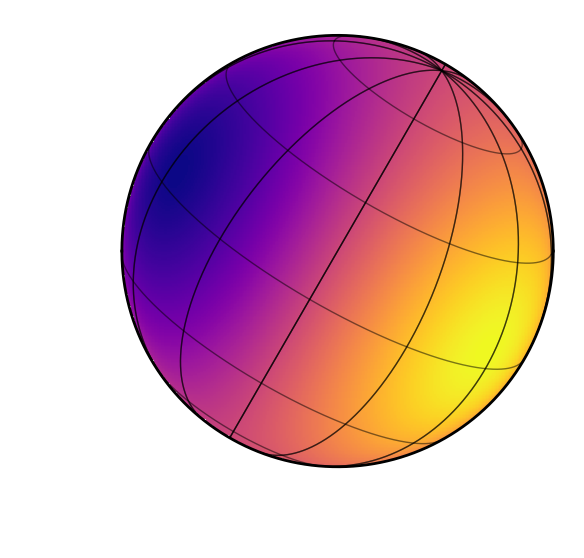

In [5]:
map.show()

In [7]:
# Define our model
map = starry.Map(udeg=udeg, doppler=True)
with pm.Model() as model:

    # Things we're fixing
    map.inc = truths["inc"]
    map.obl = truths["obl"]
    period = truths["period"]
    t0 = truths["t0"]
    b = truths["b"]
    
    # Priors on the things we're solving for
    alpha = pm.Uniform("alpha", 0.0, 1.0)
    veq = pm.Uniform("veq", 0.0, 10.0)
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    ro = pm.Uniform("ro", 0.01, 0.25)

    # Set up a Keplerian orbit for the planet
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    rv_model = map.rv(u=u, veq=veq, t=t, orbit=orbit, ro=ro, alpha=alpha)

    # Here we track the value of the model light curve for plotting later
    pm.Deterministic("rv_model", rv_model)

    # Save our initial guess
    model_guess = xo.eval_in_model(rv_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=rv_model, sd=truths["rv_err"], observed=rv)

    # Fit for the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

optimizing logp for variables: ['ro_interval__', 'u_quadlimbdark__', 'veq_interval__', 'alpha_interval__']
message: Optimization terminated successfully.
logp: -53503.863591299174 -> 621.0258118012324


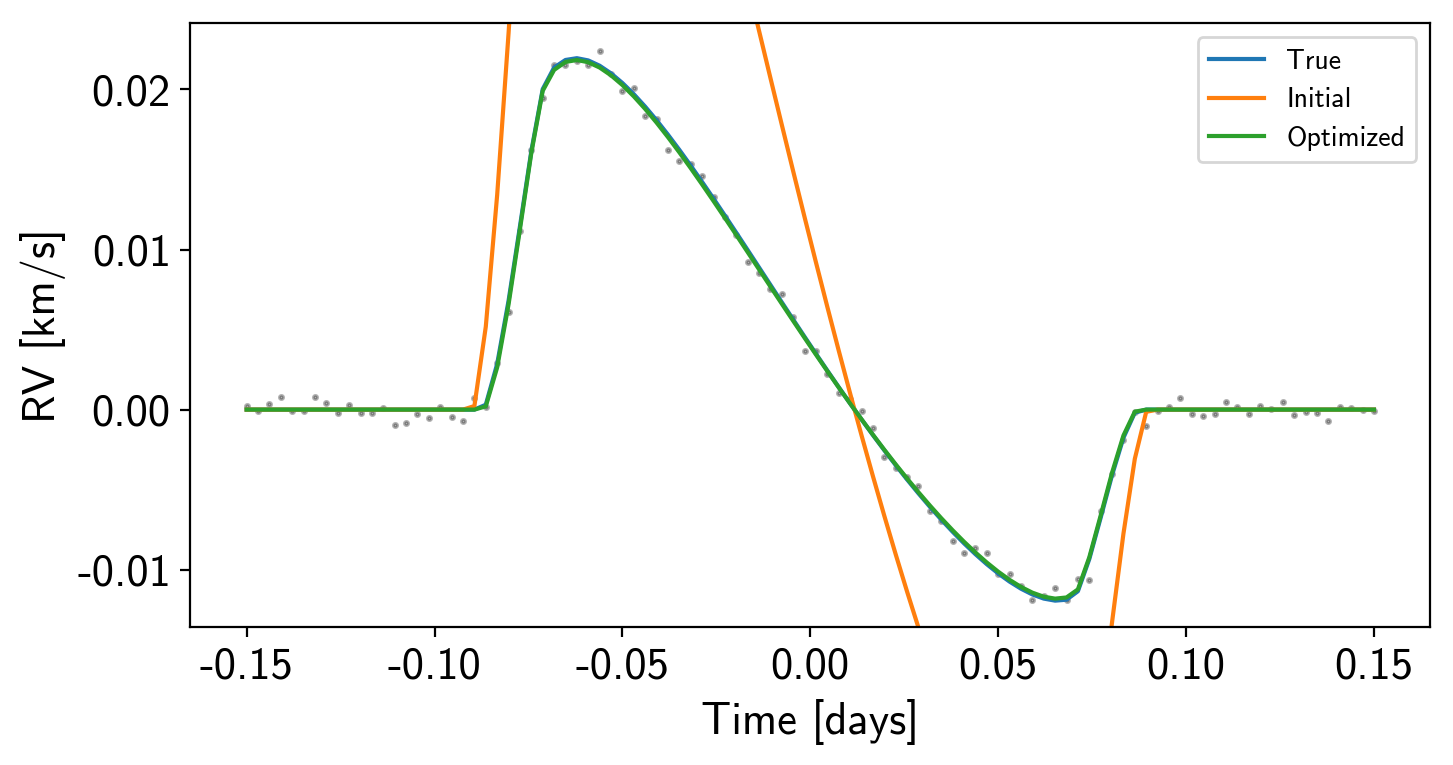

In [8]:
# Plot it
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(t, rv, 'k.', alpha=0.3, ms=3)
ax.set_ylim(*ax.get_ylim())
ax.plot(t, truths["rv"], label="True")
ax.plot(t, model_guess, label="Initial")
ax.plot(t, map_soln["rv_model"], label="Optimized")
ax.legend(fontsize=10)
ax.set_xlabel("Time [days]")
ax.set_ylabel("RV [km/s]");

In [9]:
# Sample it
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains: 100%|██████████| 808/808 [00:07<00:00, 107.77draws/s]
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ro, u, veq, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:22<00:00, 146.27draws/s]
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [10]:
pm.summary(trace, varnames=["alpha", "veq", "u", "ro"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.406026,0.022929,0.000220,0.360359,0.449354,11077.910503,1.000018
veq,3.205235,0.367845,0.007575,2.553641,3.957371,2568.813776,1.000357
u__0,0.335772,0.091999,0.000981,0.152304,0.511198,9199.337610,0.999946
u__1,0.353337,0.121084,0.001219,0.124577,0.596917,9523.921882,0.999919
ro,0.096721,0.005451,0.000108,0.085645,0.106681,2796.340356,1.000305


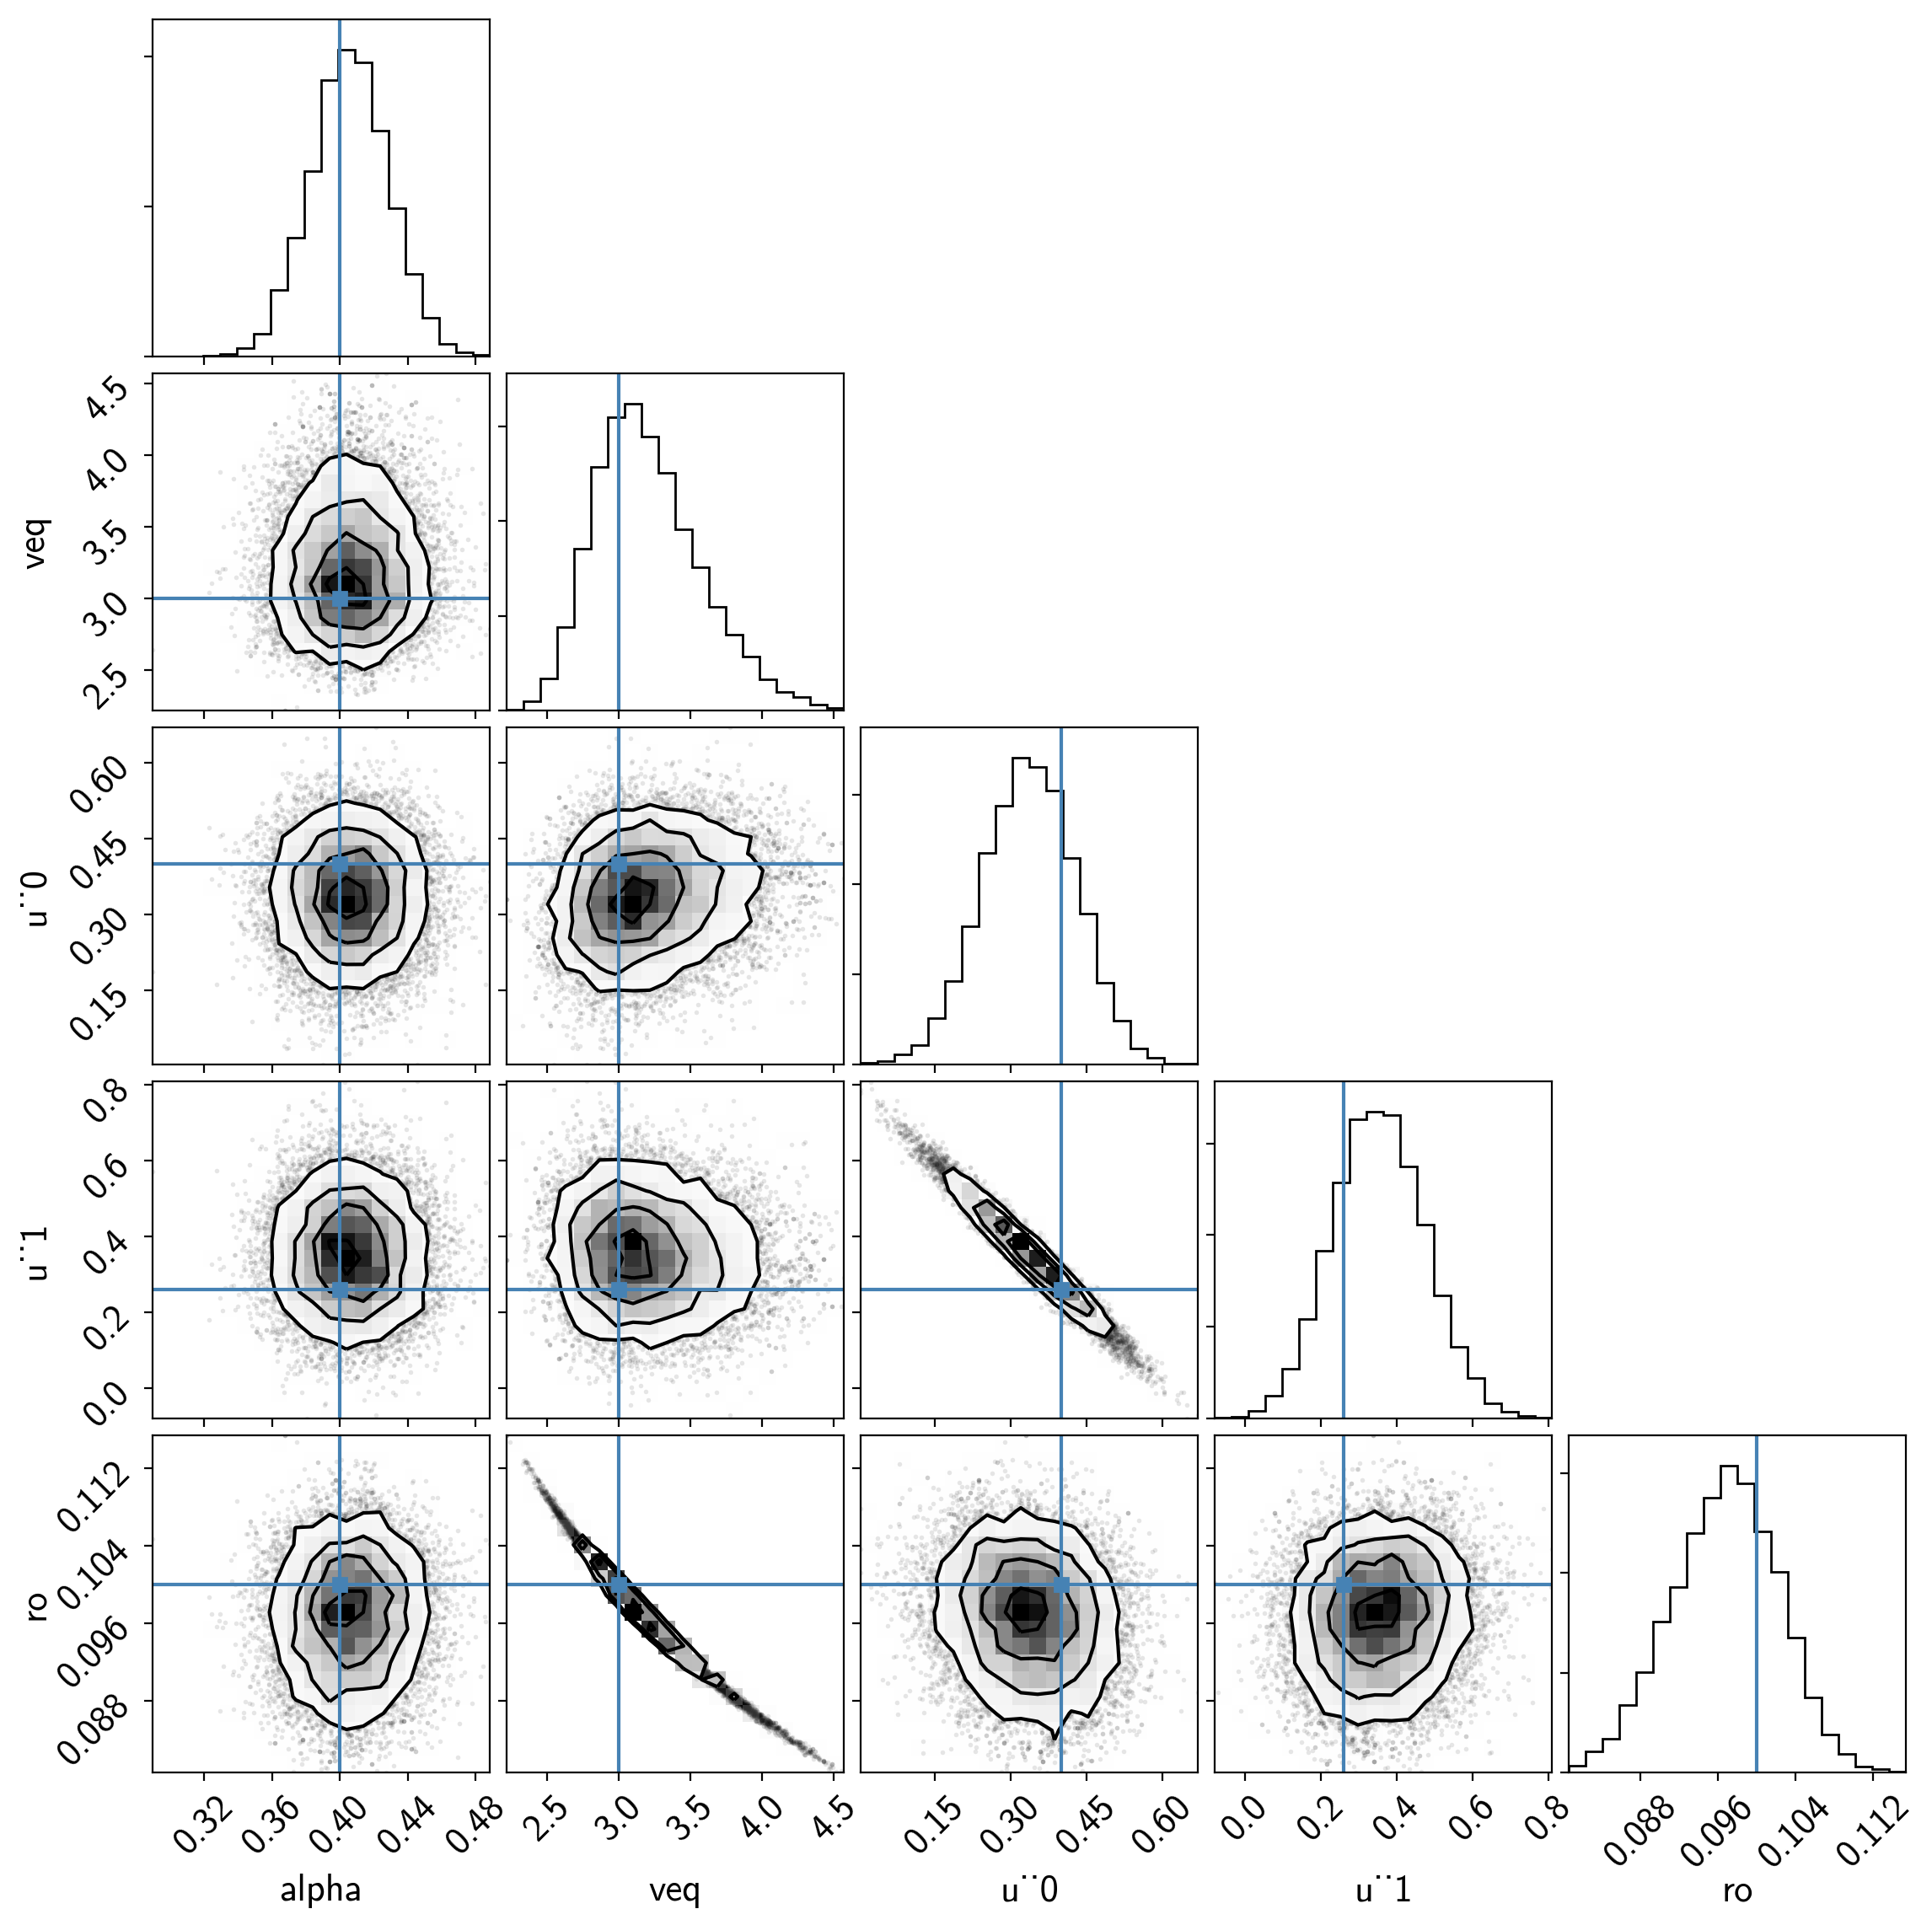

In [11]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["alpha", "veq", "u", "ro"])
corner.corner(samples, truths=[truths["alpha"], truths["veq"], truths["u"][0], truths["u"][1], truths["ro"]]);